# BTC Price Analysis
This notebook demonstrates how to visualize the Bitcoin price, the Fear & Greed index, and the predicted price from our simple linear regression model.

In [12]:
# Check for duplicate interval_end_time values in the raw JSONL data
import polars as pl
raw_df = pl.read_ndjson("../data/raw/fear_and_greed_history_5min.jsonl")
duplicates = raw_df.group_by("interval_end_time").count().filter(pl.col("count") > 1)
if duplicates.height > 0:
    print("Duplicates found:")
    print(duplicates)
else:
    print("No duplicates found.")


Duplicates found:
shape: (232, 2)
┌──────────────────────┬───────┐
│ interval_end_time    ┆ count │
│ ---                  ┆ ---   │
│ str                  ┆ u32   │
╞══════════════════════╪═══════╡
│ 2025-06-21T09:45:00Z ┆ 2     │
│ 2025-06-21T14:40:00Z ┆ 2     │
│ 2025-06-21T19:00:00Z ┆ 2     │
│ 2025-06-21T11:30:00Z ┆ 2     │
│ 2025-06-21T12:35:00Z ┆ 2     │
│ …                    ┆ …     │
│ 2025-06-21T00:40:00Z ┆ 2     │
│ 2025-06-21T10:25:00Z ┆ 2     │
│ 2025-06-21T04:05:00Z ┆ 2     │
│ 2025-06-21T06:25:00Z ┆ 2     │
│ 2025-06-21T00:30:00Z ┆ 2     │
└──────────────────────┴───────┘


/var/folders/n5/chnclgwx06ng9skf1f5bc5gr0000gp/T/ipykernel_24929/851047168.py:4: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  duplicates = raw_df.group_by("interval_end_time").count().filter(pl.col("count") > 1)


In [1]:
# Import required libraries
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [ ]:
# Check for duplicates in raw JSONL data
raw_df = pl.read_ndjson("../data/raw/fear_and_greed_history_5min.jsonl")
duplicates = raw_df.group_by("interval_end_time").count().filter(pl.col("count") > 1)
if duplicates.height > 0:
    print("Duplicates found:")
    print(duplicates)
else:
    print("No duplicates found.")


## Load the processed data
We will load the processed Bitcoin price and Fear & Greed index data from a Parquet file.

In [ ]:
# Load the processed data
df = pl.read_parquet('../data/processed/fear_and_greed_history_5min.parquet')
df.head()


avg_actual_value,close_actual_value,close_bitcoin_price_usd,high_bitcoin_price_usd,interval_end_time,low_bitcoin_price_usd,open_actual_value,open_bitcoin_price_usd,date
f64,f64,i64,i64,str,i64,f64,i64,date
55.71,55.72,103319,103319,"""2025-06-20T23:55:00Z""",103295,55.72,103302,2025-06-20
55.73,55.74,103302,103302,"""2025-06-20T23:50:00Z""",103284,55.74,103284,2025-06-20
55.75,55.76,103287,103287,"""2025-06-20T23:45:00Z""",103272,55.76,103272,2025-06-20
55.73,55.74,103270,103276,"""2025-06-20T23:40:00Z""",103243,55.74,103243,2025-06-20
55.73,55.75,103234,103234,"""2025-06-20T23:35:00Z""",103196,55.75,103196,2025-06-20


## Prepare features and target
We will use the Fear & Greed index as the feature and the BTC price as the target for our linear regression model. Rows with missing values will be dropped.

In [4]:
# Use correct column names: 'avg_actual_value' for Fear & Greed, 'close_bitcoin_price_usd' for BTC price
df = df.drop_nulls(['avg_actual_value', 'close_bitcoin_price_usd'])
X = df.select('avg_actual_value').to_numpy()
y = df.select('close_bitcoin_price_usd').to_numpy().flatten()


## Fit the linear regression model
We will fit a simple linear regression model to predict BTC price from the Fear & Greed index.

In [ ]:
# Fit linear regression model (same as train.py)
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)


## Visualize actual vs predicted BTC prices
We will plot the actual BTC prices and the predicted prices from our linear regression model to compare their trends over time.

/var/folders/n5/chnclgwx06ng9skf1f5bc5gr0000gp/T/ipykernel_24929/3454815536.py:5: UserWarning: no explicit representation of timezones available for np.datetime64
  interval_times = np.array(interval_times, dtype='datetime64[ms]')


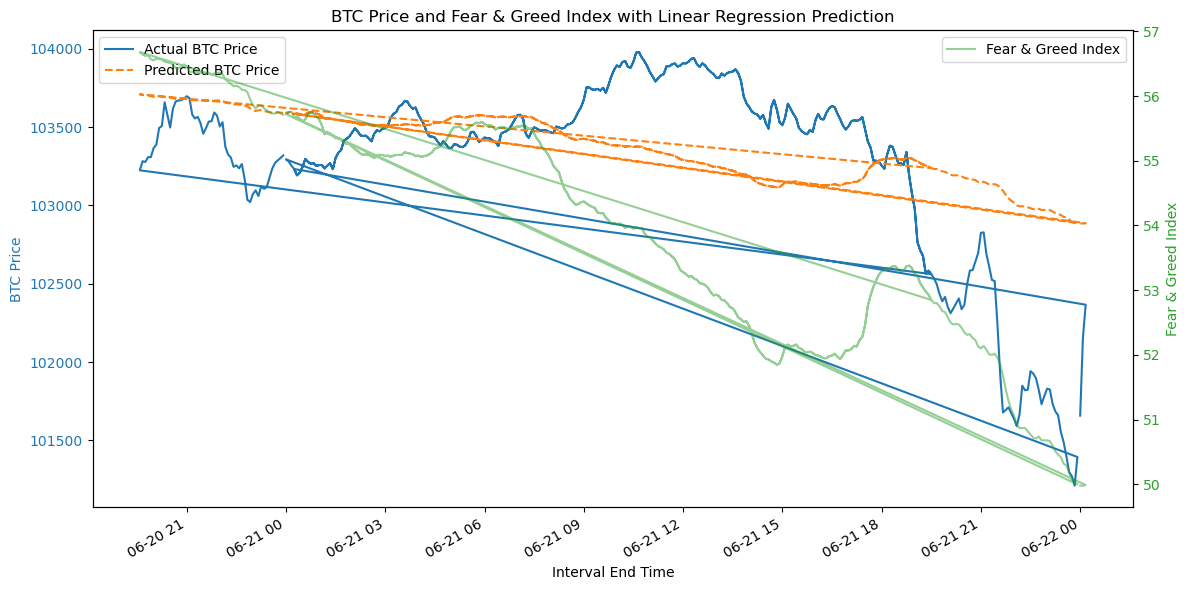

In [10]:
# Plot Fear & Greed index, actual BTC price, and predicted BTC price
import matplotlib.dates as mdates

interval_times = df.select('interval_end_time').to_numpy().flatten()
interval_times = np.array(interval_times, dtype='datetime64[ms]')
fear_greed = df.select('avg_actual_value').to_numpy().flatten()

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Interval End Time')
ax1.set_ylabel('BTC Price', color=color)
ax1.plot(interval_times, y, label='Actual BTC Price', color='tab:blue')
ax1.plot(interval_times, y_pred, label='Predicted BTC Price', color='tab:orange', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Fear & Greed Index', color=color)
ax2.plot(interval_times, fear_greed, label='Fear & Greed Index', color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.autofmt_xdate()
plt.title('BTC Price and Fear & Greed Index with Linear Regression Prediction')
plt.tight_layout()
plt.show()
